In [721]:
import pandas as pd
import numpy as np
from scipy.stats import f
from scipy.stats import t
import matplotlib.pyplot as plt

## 1) Понять есть ли тренд одинм из 3 способов:

In [765]:
data = pd.read_csv('Electric_Production.csv', sep=';')

In [766]:
Y_ = pd.DataFrame(data['IPG2211A2N'].str.replace(',', '.'), dtype = float).values
D = pd.to_datetime(data['DATE'])

In [767]:
Y = [i[0] for i in Y_]

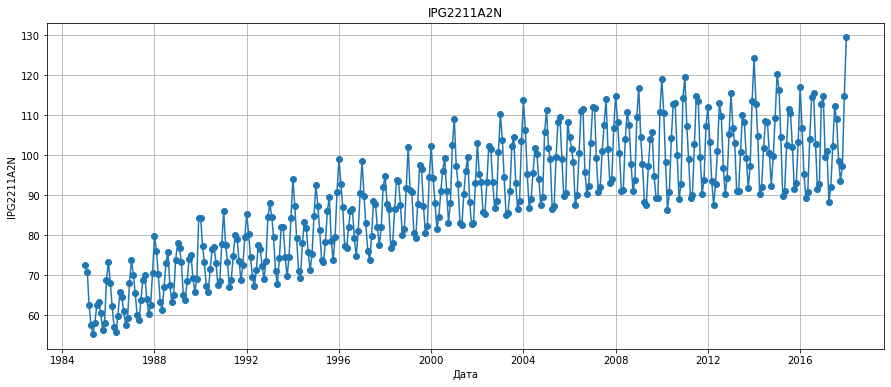

In [768]:
plt.figure(figsize=(15, 6))
plt.plot(D, Y, marker='o')

plt.xlabel('Дата')
plt.ylabel('IPG2211A2N')
plt.title('IPG2211A2N')
plt.grid(True)
plt.show()

Метод проверки разности средних уровней

In [769]:
n=len(data)
ny1 = Y[:n//2]
ny2 = Y[n//2:]

In [770]:
n1 = len(ny1)
n2 = len(ny2)

In [771]:
n1 + n2 == n

True

In [772]:
avgy1 = np.mean(ny1)
avgy2 = np.mean(ny2)
vary1 = np.var(ny1)
vary2 = np.var(ny2)

In [773]:
avgy1, avgy2, vary1, vary2

(77.40359141414143, 100.23333819095478, 121.47413934159292, 90.38513111633041)

In [774]:
F = max(vary1,vary2)/min(vary1,vary2)
F

1.3439615326247556

In [775]:
alpha = 0.01
f_crit = f.ppf(1 - alpha, n1, n2)
f_crit

1.392837238011871

In [776]:
F<f_crit #гипотеза о равенстве дисперсий принимается

True

In [777]:
std = (((n1-1)*vary1 + (n2-1)*vary2)/(n1+n2-2))*0.5
t_r = abs(avgy1-avgy2)/(std*(1/n1 + 1/n2)*0.5)
t_r

85.59191446967863

In [778]:
alpha = 0.01
t_crit = t.ppf(1 - alpha / 2, n-2)
t_crit

2.588333081057898

In [779]:
t_r>t_crit #тренд есть

True

## 2) определить тип тренда (вид временного ряда)

In [780]:
len(Y)

397

In [781]:
delta_values = [0]
for i in range(1, len(Y)-1):
    y_prev = Y[i - 1]
    y_current = Y[i + 1]
    delta_values.append((y_current - y_prev)/2)
delta_values.append(0)
delta_values = np.array(delta_values)

In [782]:
len(delta_values)

397

In [783]:
delta2_values = [0]
for i in range(1, len(delta_values)-1):
    y_prev = delta_values[i - 1]
    y_current = delta_values[i + 1]
    delta2_values.append((y_current - y_prev)/2)
delta2_values.append(0)
delta2_values = np.array(delta2_values)

In [784]:
len(delta2_values)

397

In [785]:
data['delta'] = delta_values
data['delta_delta'] = delta2_values
data['delta/y'] = delta_values / Y
data['IPG2211A2N'] = Y
data['DATE'] = D
data.head()

,DATE,IPG2211A2N,delta,delta_delta,delta/y
0,1985-01-01,72.5052,0.00000,0.000000,0.000000
1,1985-02-01,70.6720,-5.02750,-3.300150,-0.071138
2,1985-03-01,62.4502,-6.60030,0.729975,-0.105689
3,1985-04-01,57.4714,-3.56755,3.454900,-0.062075
4,1985-05-01,55.3151,0.30950,3.610050,0.005595


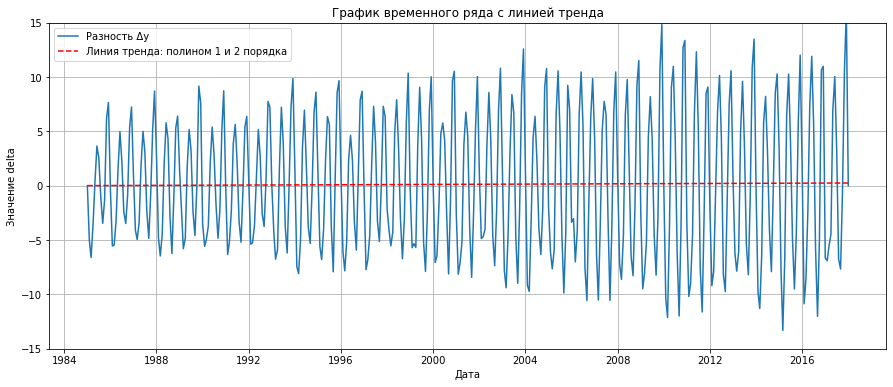

In [786]:
plt.figure(figsize=(15, 6))
plt.plot(data['DATE'], data['delta'], label='Разность Δy')

# Линия тренда
z = np.polyfit(range(len(data)), data['delta'], 1)
p = np.poly1d(z)
plt.plot(data['DATE'], p(range(len(data))), linestyle='--', color='red', label='Линия тренда: полином 1 и 2 порядка')

plt.xlabel('Дата')
plt.ylim((-15, 15))
plt.ylabel('Значение delta')
plt.title('График временного ряда с линией тренда')
plt.legend()
plt.grid(True)
plt.show()

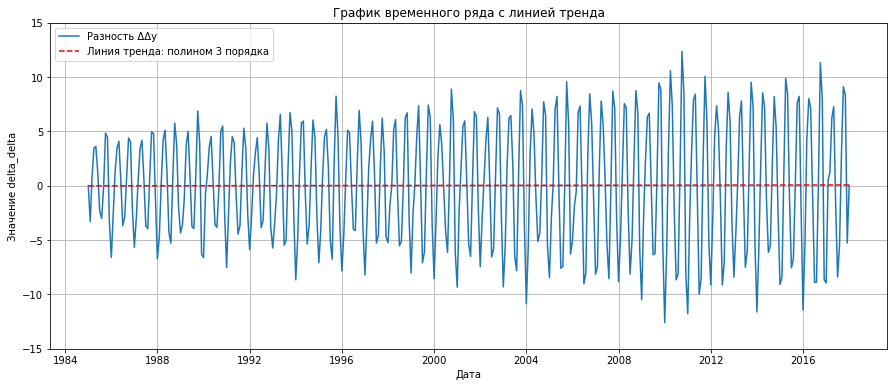

In [787]:
plt.figure(figsize=(15, 6))
plt.plot(data['DATE'], data['delta_delta'], label='Разность ΔΔy')

# Линия тренда
z = np.polyfit(range(len(data)), data['delta_delta'], 1)
p = np.poly1d(z)
plt.plot(data['DATE'], p(range(len(data))), linestyle='--', color='red', label='Линия тренда: полином 3 порядка')

plt.xlabel('Дата')
plt.ylim((-15, 15))

plt.ylabel('Значение delta_delta')
plt.title('График временного ряда с линией тренда')
plt.legend()
plt.grid(True)
plt.show()

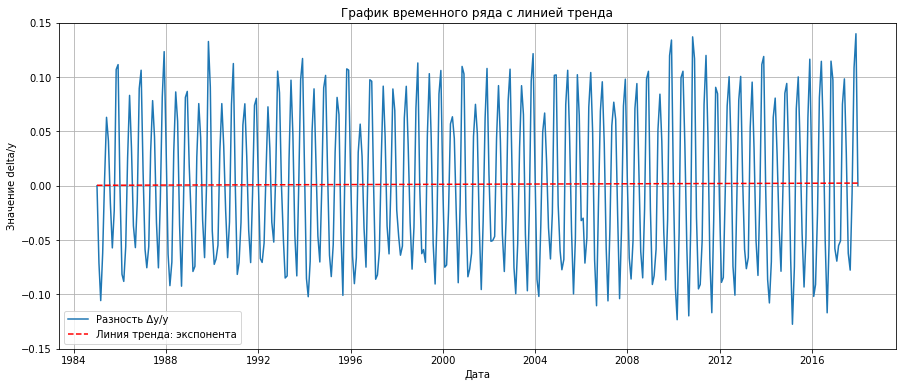

In [788]:
plt.figure(figsize=(15, 6))
plt.plot(data['DATE'], data['delta/y'], label='Разность Δy/y')

# Линия тренда
z = np.polyfit(range(len(data)), data['delta/y'], 1)
p = np.poly1d(z)
plt.plot(data['DATE'], p(range(len(data))), linestyle='--', color='red', label='Линия тренда: экспонента')

plt.xlabel('Дата')
plt.ylabel('Значение delta/y')
plt.title('График временного ряда с линией тренда')
plt.ylim((-0.15, 0.15))
plt.legend()
plt.grid(True)
plt.show()

### Характер изменений везде примерно постоянный -> Кривая роста либо полином первого порядка, либо экспонента

In [789]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [790]:
# Создаем фиктивные переменные по месяцам
month_dummies = pd.get_dummies(data['DATE'].dt.month, prefix='month')
X = month_dummies
month_dummies.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0


In [791]:
X_train, X_test, y_train, y_test = X[:-30], X[-30:], Y[:-30], Y[-30:]

In [792]:
# Линейная регрессия
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_r2 = r2_score(y_test, linear_model.predict(X_test))

print("R^2 для линейной регрессии:", linear_r2)

R^2 для линейной регрессии: -1.9744156821825585


In [793]:
r2_score(y_test, [np.mean(np.array(y_train))]*len(y_test)) #для среднего значения еще хуже

-2.2289268091398644

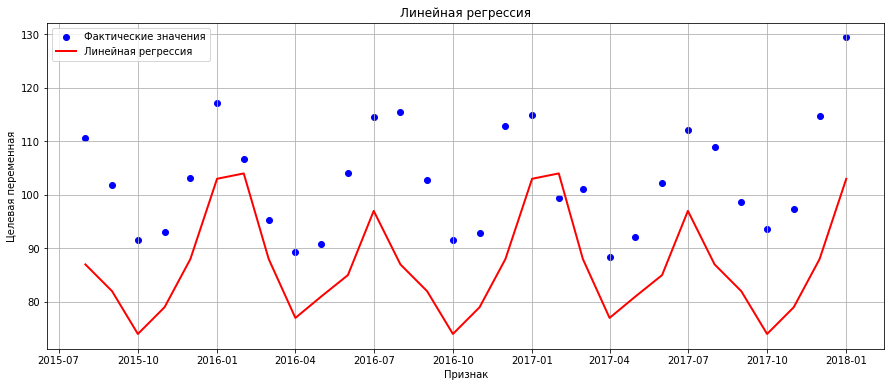

In [794]:
plt.figure(figsize=(15, 6))
plt.scatter(data['DATE'][-30:], y_test, color='blue', label='Фактические значения')

# Линия регрессии
plt.plot(data['DATE'][-30:], linear_model.predict(X_test), color='red', linewidth=2, label='Линейная регрессия')

plt.title('Линейная регрессия')
plt.xlabel('Признак')
plt.ylabel('Целевая переменная')
plt.legend()
plt.grid(True)
plt.show()

In [795]:
# Квадратичная регрессия
quadratic_features = PolynomialFeatures(degree=2)
X_train_quadratic = quadratic_features.fit_transform(X_train)
X_test_quadratic = quadratic_features.transform(X_test)
quadratic_model = LinearRegression()
quadratic_model.fit(X_train_quadratic, y_train)
y_pred_quadratic = quadratic_model.predict(X_test_quadratic)

quadratic_r2 = r2_score(y_test, y_pred_quadratic)
print("R^2 для квадратичной модели:", quadratic_r2)

R^2 для квадратичной модели: -1.483164937777361


In [796]:
# Кубическая регрессия
cubic_features = PolynomialFeatures(degree=3)
X_train_cubic = quadratic_features.fit_transform(X_train)
X_test_cubic = quadratic_features.transform(X_test)
cubic_model = LinearRegression()
cubic_model.fit(X_train_cubic, y_train)

cubic_r2 = r2_score(y_test, cubic_model.predict(X_test_cubic))
print("R^2 для кубической регрессии:", cubic_r2)

R^2 для кубической регрессии: -1.483164937777361


In [797]:
# Экспоненциальная регрессия
exp_model = LinearRegression()
exp_model.fit(X_train, np.log(y_train))

exp_r2 = r2_score(y_test, np.exp(exp_model.predict(X_test)))
print("R^2 для экспоненциальной регрессии:", exp_r2)

R^2 для экспоненциальной регрессии: -2.1208342931567103


In [798]:
print("R^2 для линейной регрессии:", linear_r2)
print("R^2 для квадратичной регрессии:", quadratic_r2)
print("R^2 для кубической регрессии:", cubic_r2)
print("R^2 для экспоненциальной регрессии:", exp_r2)

R^2 для линейной регрессии: -1.9744156821825585
R^2 для квадратичной регрессии: -1.483164937777361
R^2 для кубической регрессии: -1.483164937777361
R^2 для экспоненциальной регрессии: -2.1208342931567103


### Судя по r^2 лучше квадратичная или кубическая модель

# Сезонность

In [799]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [800]:
data.drop(['delta','delta_delta', 'delta/y'], axis=1, inplace=True)

In [801]:
data.dtypes

DATE          datetime64[ns]
IPG2211A2N           float64
dtype: object

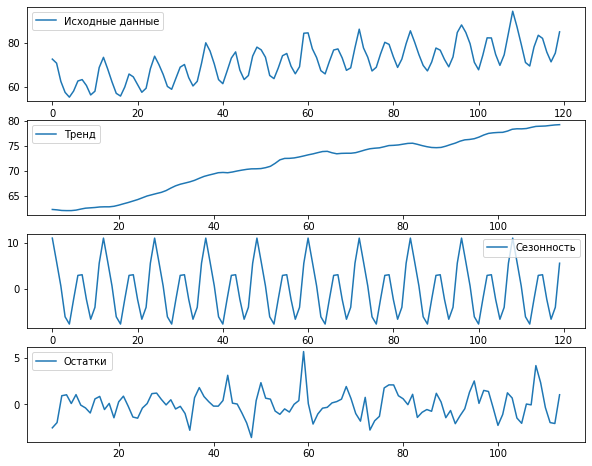

In [802]:
result = seasonal_decompose(data['IPG2211A2N'][:12*10], model='additive', period=12)  # Период равен 12 месяцам

# Визуализация разложения
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(data['IPG2211A2N'][:12*10], label='Исходные данные')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Тренд')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Сезонность')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Остатки')
plt.legend()

plt.show()

In [803]:
data2 = data.set_index('DATE')
decomposition = seasonal_decompose(data2)

In [805]:
result = seasonal_decompose(data['IPG2211A2N'], model='additive', period=12)  # Период равен 12 месяцам
for i in range(len(decomposition.seasonal[:12])):
    print(i+1, decomposition.seasonal[i])


1 13.213039338699499
2 5.74474728140783
3 -0.4936796717171698
4 -9.47835506234217
5 -9.222160400883839
6 -1.168423551925504
7 6.143013888888888
8 6.274451448074495
9 -2.447828109217173
10 -8.853353890467172
11 -6.039535921717174
12 6.32808465119949


#### январь - первый месяц - сезонность выше
#### апрель - четвертый месяц - сезонность ниже; следующий по списку май

# Остатки 

In [806]:
import statsmodels.api as sm

X = sm.add_constant(X)

# Создаем модель линейной регрессии с помощью OLS
model = sm.OLS(Y, X)

# Обучаем модель
results = model.fit()

# Выводим статистику модели
print(results.summary())

# Получаем прогнозы
predictions = results.predict(X)

# Получаем остатки
residuals = results.resid

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     10.02
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           4.34e-16
Time:                        01:07:07   Log-Likelihood:                -1598.1
No. Observations:                 397   AIC:                             3220.
Df Residuals:                     385   BIC:                             3268.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.9819      0.637    128.601      0.0

### + скользящие средние

In [849]:
month_dummies = pd.get_dummies(data['DATE'].dt.month, prefix='month')
X = month_dummies
month_dummies.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
4,0,0,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0


In [850]:
# Предположим, что df - это ваш DataFrame с данными

# Создаем скользящие средние
window_size = 3  # Размер окна для скользящего среднего
rolling_mean = pd.DataFrame(Y).rolling(window=window_size).mean()

In [851]:
# Добавляем столбцы со скользящими средними в DataFrame
X['rolling_mean_3'] = rolling_mean

In [853]:
# Удаляем строки, в которых есть пропущенные значения после создания скользящего среднего
data.dropna(inplace=True)

# Преобразуем данные в массивы NumPy
X = np.asarray(X)
y = np.asarray(data['IPG2211A2N'])

In [854]:
X = sm.add_constant(X)  # Добавляем столбец с единицами для учета свободного члена

In [855]:
# Создаем модель линейной регрессии с помощью OLS
model = sm.OLS(y, X)

# Обучаем модель
results = model.fit()

# Выводим статистику модели
print(results.summary())

# Получаем прогнозы
predictions = results.predict(X)

# Получаем остатки
residuals = results.resid

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1617.
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          1.44e-317
Time:                        01:22:39   Log-Likelihood:                -851.88
No. Observations:                 393   AIC:                             1730.
Df Residuals:                     380   BIC:                             1781.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2859      0.680      0.420      0.6